In [1]:
from scipy.sparse import dia_matrix
import inspect
from astropy.table import Table
import numpy as np  
import matplotlib.pyplot as plt


def EMCCDhist(x, bias=[1e3, 4.5e3,1194], RN=[0,200,53], EmGain=[100, 10000,5000], flux=[0.001, 1,0.04], smearing=[0, 3,0.31], sCIC=[0,1,0]):
# def EMCCDhist(x, bias=[1e3, 4.5e3,1194], RN=[0,200,53], EmGain=[100, 10000,5000], flux=[0.001, 1,0.04], smearing=[0, 3,0.31], sCIC=[0,1,0],SmearExpDecrement=[1.5e3,1.5e5,15e4]):
    

    def variable_smearing_kernels(image, Smearing=1.5, SmearExpDecrement=50000):
        """Creates variable smearing kernels for inversion
        """
        n=6
        smearing_length = Smearing * np.exp(-image / SmearExpDecrement)
        smearing_kernels = np.exp(-np.arange(n)[:, np.newaxis, np.newaxis] / smearing_length)
        smearing_kernels /= smearing_kernels.sum(axis=0)
        return smearing_kernels


    def simulate_fireball_emccd_hist(
        x,
        ConversionGain,
        EmGain,
        Bias,
        RN,
        p_pCIC,
        p_sCIC,
        Smearing,
        SmearExpDecrement,
        n_registers,
        flux,
        sCIC=0,
    ):
        """Silumate EMCCD histogram
        """
        import numpy as np
        n_pix=10**4.3   

        n=1
        im = np.zeros((1000,int(n_pix/1000)))
        # factor = 1#np.log(2)
        # EmGain *= factor
        # imaADU = np.random.gamma(flux, EmGain, size=im.shape)
        imaADU = np.random.gamma(np.random.poisson(flux, size=im.shape), EmGain)
        #Add pCIC (no interest, as flux)
        # imaADU[np.random.rand(size[1],size[0]) <  p_pCIC] += 1 

        # pixels in which sCIC electron might appear
        id_scic = np.random.rand(im.shape[0], im.shape[1]) < sCIC  # sCIC positions
        # stage of the EM register at which each sCIC e- appear
        register = np.random.randint(1, n_registers, size=id_scic.sum())
        # Compute and add the partial amplification for each sCIC pixel
        imaADU[id_scic] += np.random.exponential(np.power(EmGain, register / n_registers))
        imaADU *= ConversionGain

        if Smearing > 0:
            smearing_kernels = variable_smearing_kernels(imaADU, Smearing, SmearExpDecrement)
            offsets = np.arange(6)
            A = dia_matrix((smearing_kernels.reshape((6, -1)), offsets),shape=(imaADU.size, imaADU.size),)
            imaADU = A.dot(imaADU.ravel()).reshape(imaADU.shape)
        read_noise = np.random.normal(0, RN * ConversionGain, size=im.shape)        
        imaADU += Bias
        imaADU += read_noise
        range = [np.nanmin(x), np.nanmax(x)]
        n, bins = np.histogram(imaADU.flatten(), range=range, bins=len(x))
        # return np.convolve(n,np.ones(3)/3,mode='same')
        return n

    y = simulate_fireball_emccd_hist(
        x=x,
        ConversionGain=1 / 4.5,  # 0.53,
        EmGain=EmGain,
        Bias=bias,
        RN=RN,
        p_pCIC=0,
        p_sCIC=0,   
        Smearing=smearing,
        SmearExpDecrement=1e4,
        n_registers=604,
        flux=flux,
        sCIC=sCIC)
    y[y==0]=1
    return np.log10(y)


interactive(children=(IntRangeSlider(value=(50, 50), description='RN', layout=Layout(width='500px'), max=200),…

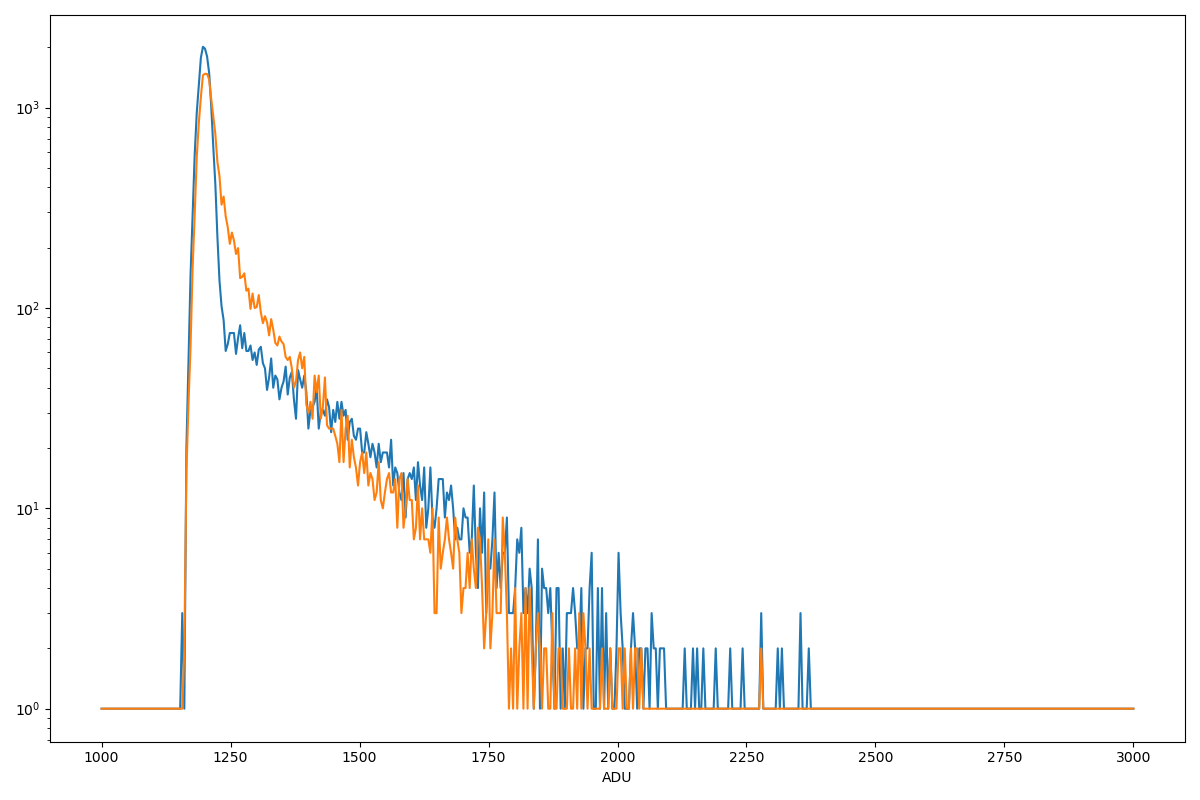

In [2]:
import ipywidgets as widgets
%matplotlib widget

x=np.linspace(1000,3000,500)
emgain=800
RN=50
flux=0.3
smearing1, smearing2 = 0,0.8
sCIC=0.01
fig, ax = plt.subplots(figsize=(12,8))
l=ax.semilogy(x,10**EMCCDhist(x, bias=1200, RN=RN, EmGain=emgain, flux=flux, smearing=smearing1, sCIC=sCIC))
l2=ax.semilogy(x,10**EMCCDhist(x, bias=1200, RN=RN, EmGain=emgain, flux=flux, smearing=smearing2, sCIC=sCIC))
ax.set_xlabel('ADU')
ax.set_xlabel('ADU')
fig.tight_layout()
# plt.show()
from ipywidgets import Button, Layout, jslink, IntText, IntSlider, interactive, interact, HBox, Layout, VBox


# @widgets.interact(bias=(1000, 2000,1194), RN=(0.,200.,53.), EmGain=(100, 10000,5000), flux=(0.001, 1,0.04), smearing=(0, 3,0.31), sCIC=(0,1,0.1))
def view_image( RN, EmGain, flux, smearing, sCIC):
    # with widgets.Output():
    flux1, flux2 = flux
    RN1, RN2 = RN
    EmGain1, EmGain2 = EmGain
    smearing1,smearing2=smearing
    sCIC1,sCIC2=sCIC
    emccd = EMCCDhist(x, 1200, RN1, EmGain1, flux1, smearing1, sCIC1)
    emccd2 = EMCCDhist(x, 1200, RN2, EmGain2, flux2, smearing2, sCIC2)
    ax.lines[0].set_data(x,10**emccd)
    ax.lines[1].set_data(x,10**emccd2)


 
rn = widgets.IntRangeSlider( min=0, max=200,value=[RN,RN], layout=Layout(width='500px'))
gain = widgets.IntRangeSlider( min=500, max=1500,value=[emgain,emgain], layout=Layout(width='500px'))

flux =  widgets.FloatRangeSlider(value=[flux, flux],min=0.001,max=1,step=0.001,readout_format='.1f', layout=Layout(width='500px'))
smearing =  widgets.FloatRangeSlider( min=0.0, max=3,value=[smearing1,smearing2], layout=Layout(width='500px'),readout_format='.2f')
sCIC =  widgets.FloatRangeSlider( min=0.0, max=1,value=[sCIC,sCIC], layout=Layout(width='500px'),readout_format='.2f')
a = interact(view_image, RN=rn, EmGain=gain, flux=flux, smearing=smearing, sCIC=sCIC)

In [3]:


# x=np.linspace(1000,3000,100)
# fig, ax = plt.subplots(figsize=(12,8))
# l=ax.plot(x,EMCCDhist(x, bias=1194, RN=50, EmGain=1000, flux=0.001, smearing=0.0, sCIC=0.01))
# # l2=ax.plot(x,EMCCDhist(x, bias=1194, RN=50, EmGain=1000, flux=0.001, smearing=0.0, sCIC=0.01))

# fig.tight_layout()
# # plt.show()
# from ipywidgets import Button, Layout, jslink, IntText, IntSlider, interactive, interact, HBox, Layout, VBox


# # @widgets.interact(bias=(1000, 2000,1194), RN=(0.,200.,53.), EmGain=(100, 10000,5000), flux=(0.001, 1,0.04), smearing=(0, 3,0.31), sCIC=(0,1,0.1))
# def view_image(bias, RN, EmGain, flux, smearing, sCIC):
#     with widgets.Output():
#         print(bias)
#         emccd = EMCCDhist(x, bias, RN, EmGain, flux, smearing, sCIC)
#     #     ax.plot(x,emccd)
#         ax.lines[0].set_data(x,emccd)

# bias = widgets.IntSlider( min=1e3, max=1.4e3,value=1194)
# rn = widgets.IntSlider( min=0, max=200,value=53)
# gain = widgets.IntSlider( min=1000, max=4000,value=1200)
# flux =  widgets.FloatSlider( min=0.001, max=1,value=0.01)
# smearing =  widgets.FloatSlider( min=0.0, max=3,value=0.0)
# sCIC =  widgets.FloatSlider( min=0.0, max=1,value=0.01)
# a = interact(view_image,bias=bias, RN=rn, EmGain=gain, flux=flux, smearing=smearing, sCIC=sCIC)

In [4]:
# %matplotlib widget

# x=np.linspace(1000,3000,100)
# fig, ax = plt.subplots(figsize=(12,8))
# l=ax.plot(x,EMCCDhist(x, bias=1194, RN=50, EmGain=1000, flux=0.05, smearing=0, sCIC=0))
# fig.tight_layout()
# # plt.show()

# @widgets.interact(bias=(1000, 2000,1194), RN=(0.,200.,53.), EmGain=(100, 10000,5000), flux=(0.001, 1,0.04), smearing=(0, 3,0.31), sCIC=(0,1,0.1))
# def view_image(bias, RN, EmGain, flux, smearing, sCIC):
#     with widgets.Output():
#         print(bias)
#         emccd = EMCCDhist(x, bias, RN, EmGain, flux, smearing, sCIC)
#     #     ax.plot(x,emccd)
#         ax.lines[0].set_data(x,emccd)
# #     fig.canvas.draw()